# Deep Learning Development

## Import Library

In [1]:
import sys
import os
import importlib
import numpy as np
from pathlib import Path
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from einops import rearrange

# Add the parent directory to the path so Python can find 'scripts'
sys.path.append(os.path.abspath('..'))

# Reload the modules to get the latest changes
import script.myModules.models.pytorch_lightning as pm  # noqa: E402
import script.myModules.utils.data_utils as du  # noqa: E402
import script.myModules.utils.utility as ut  # noqa: E402
importlib.reload(du)
importlib.reload(pm)

# ut.set_seed(42)
pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 42


## Utility Functions

In [2]:
# Check if CUDA is available
gpu_count = ut.cuda_device_count()
cuda_available = ut.cuda_is_available()
print(f'GPU count: {gpu_count}, CUDA available: {cuda_available}')

GPU count: 1, CUDA available: True


## Step 1: Load Truncated Dataset

- There are several configurations of truncated dataset as follows:
  - Task: `GNG`
    - _Configuration 1_:
      - `fs` = 10.1 Hz, 
      - `fixed_length_time` = 240s or 60s/task
      - `fixed_length_time_window` = $240s \times{10.1\text{ Hz}} = 2424$ samples
- Aggregate the Dataset based on the `torch.nn` layer
  - `Conv1D`: $(N, C_{in}, L_{in})$ or $(C_{in}, L_{in})$
  - `Conv2D`: $(N, C_{in}, H_{in}, W_{in})$ or $(C_{in}, H_{in}, W_{in})$
  - `LSTM`: 
    - `batch_first=False` ➡️ $(L_{in}, N, H_{in})$
    - `batch_first=True` ➡️ $(N, L, H_{in})$

### 1. Load the RAW Dataset Based on The Task Type

In [3]:
df_10_1_Hz_truncated = Path('../../data/truncated/10_1_Hz')
task_type = 'GNG'

fNIRS_data_dict = du.load_concatenated_fNIRS_data(df_10_1_Hz_truncated, task_type)

### 2. Prepare the Dataset To Have Similar Strucutre Like the Dummy Dataset

In [4]:
data, labels = du.create_data_and_labels(fNIRS_data_dict)

# Print unique labels and count
print(f'Unique labels: {np.unique(labels)}')
print(f'Label count: {np.bincount(labels)}')

print(f"data shape: {data.shape}")  # Should print (num_samples, channels, time)
print(f"labels shape: {labels.shape}")  # Should print (num_samples,)

if len(data) != len(labels):
    raise ValueError(f"Mismatch between data samples ({len(data)}) and labels ({len(labels)})")

Unique labels: [0 1]
Label count: [33 18]
data shape: (51, 69, 2424)
labels shape: (51,)


#### 2.1. Signal Data into 1D-Shape Visualization

Sample data shape: (69, 2424)


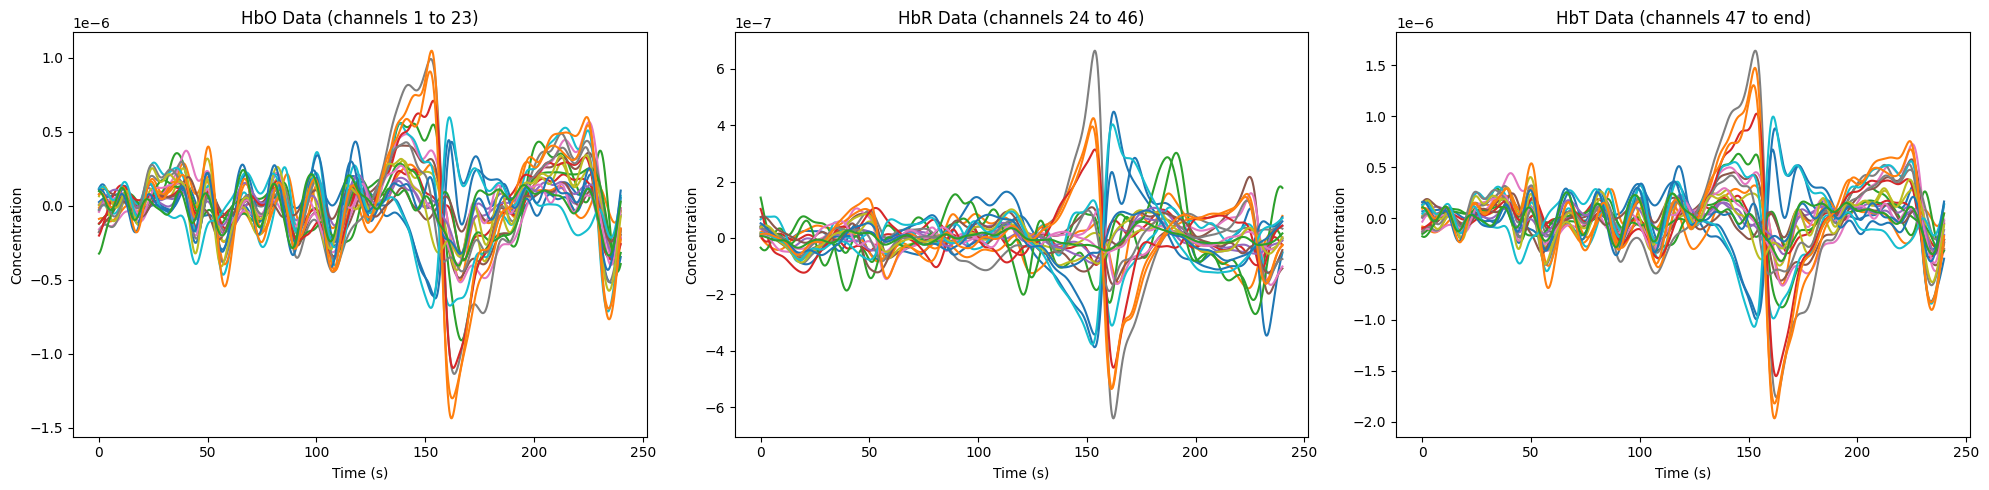

In [5]:
# Pick a random sample to plot
sample_idx = np.random.randint(len(data))
sample_data = data[sample_idx]
sample_label = labels[sample_idx]

# Check the shape
print(f"Sample data shape: {sample_data.shape}")  # Should print (channels, time)

# Extract the HbO only Data which is the first index to 23th index
sample_data_hbo = sample_data[:23]
sample_data_hbr = sample_data[23:46]
sample_data_hbt = sample_data[46:]
fs = 10.1  # Sampling frequency
time = np.arange(0, len(sample_data_hbo[0]) / fs, 1 / fs)

# Plot the sample data
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(time, sample_data_hbo.T)
axs[0].set_title('HbO Data (channels 1 to 23)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Concentration')

axs[1].plot(time, sample_data_hbr.T)
axs[1].set_title('HbR Data (channels 24 to 46)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Concentration')

axs[2].plot(time, sample_data_hbt.T)
axs[2].set_title('HbT Data (channels 47 to end)')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Concentration')

plt.tight_layout()
plt.show()

#### 2.2. Signal Data into 2D-Shape Visualization

Sample data shape: (69, 2424)
sample_data_2d_hbo shape: (1, 23, 2424)


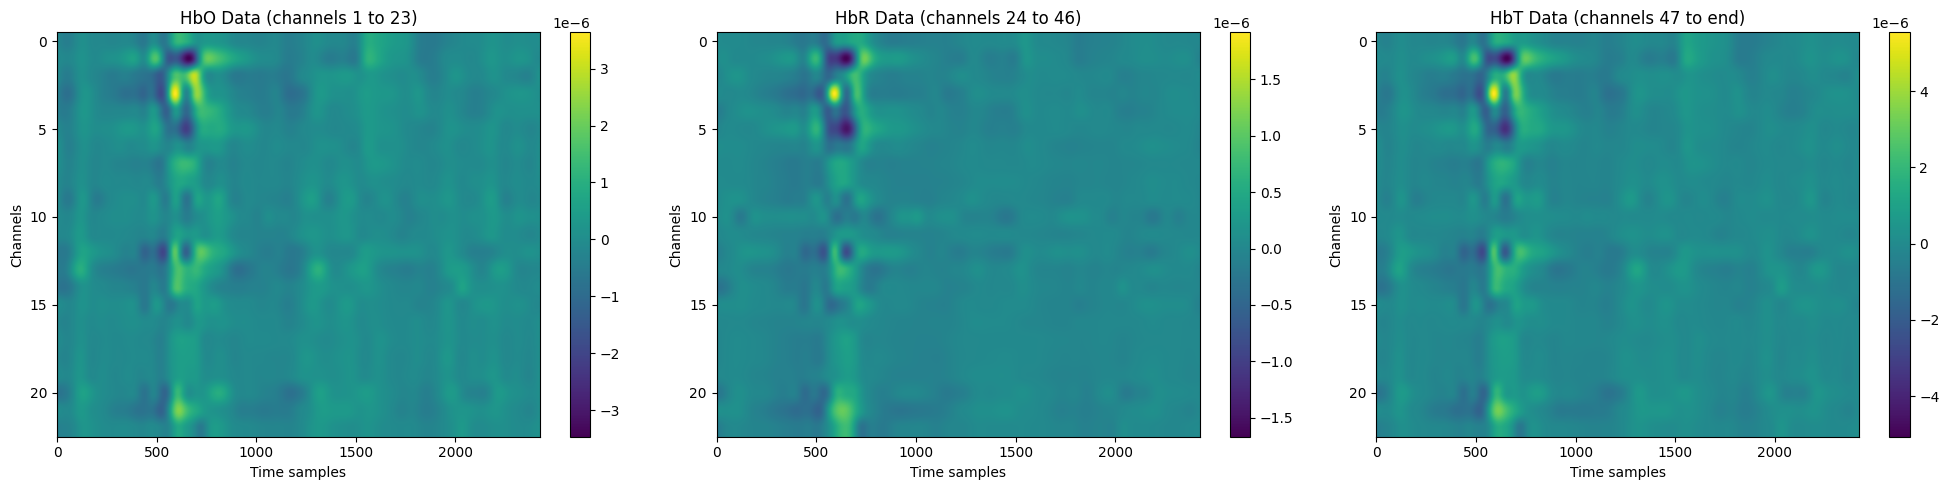

In [6]:
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' has shape (batch_size, channels, time_samples)
# Extract random subject data
sample_idx = np.random.randint(len(data))
sample_data = data[sample_idx]
sample_label = labels[sample_idx]

# Check the shape
print(f"Sample data shape: {sample_data.shape}")  # Should print (channels, time

# Extract the HbO only Data which is the first index to 23rd index
sample_data_hbo = sample_data[:23]
sample_data_hbr = sample_data[23:46]
sample_data_hbt = sample_data[46:]
fs = 10.1  # Sampling frequency
time = np.arange(0, len(sample_data_hbo[0]) / fs, 1 / fs)

# Use einops to add a dummy channel dimension, converting the data to 2D (1, 23, time_samples)
sample_data_2d_hbo = rearrange(sample_data_hbo, 'c t -> () c t')
sample_data_2d_hbr = rearrange(sample_data_hbr, 'c t -> () c t')
sample_data_2d_hbt = rearrange(sample_data_hbt, 'c t -> () c t')

# Print the new shape
print(f"sample_data_2d_hbo shape: {sample_data_2d_hbo.shape}")

# Create a subplot with 3 columns and one row
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Visualize the HbO data
im0 = axs[0].imshow(sample_data_2d_hbo[0], aspect='auto')
axs[0].set_title('HbO Data (channels 1 to 23)')
axs[0].set_xlabel('Time samples')
axs[0].set_ylabel('Channels')
fig.colorbar(im0, ax=axs[0])

# Visualize the HbR data
im1 = axs[1].imshow(sample_data_2d_hbr[0], aspect='auto')
axs[1].set_title('HbR Data (channels 24 to 46)')
axs[1].set_xlabel('Time samples')
axs[1].set_ylabel('Channels')
fig.colorbar(im1, ax=axs[1])

# Visualize the HbT data
im2 = axs[2].imshow(sample_data_2d_hbt[0], aspect='auto')
axs[2].set_title('HbT Data (channels 47 to end)')
axs[2].set_xlabel('Time samples')
axs[2].set_ylabel('Channels')
fig.colorbar(im2, ax=axs[2])

# Adjust layout
plt.tight_layout()
plt.show()

**Plot the Dataset Distribution**

The class counts are: Alive    33
Death    18
Name: count, dtype: int64


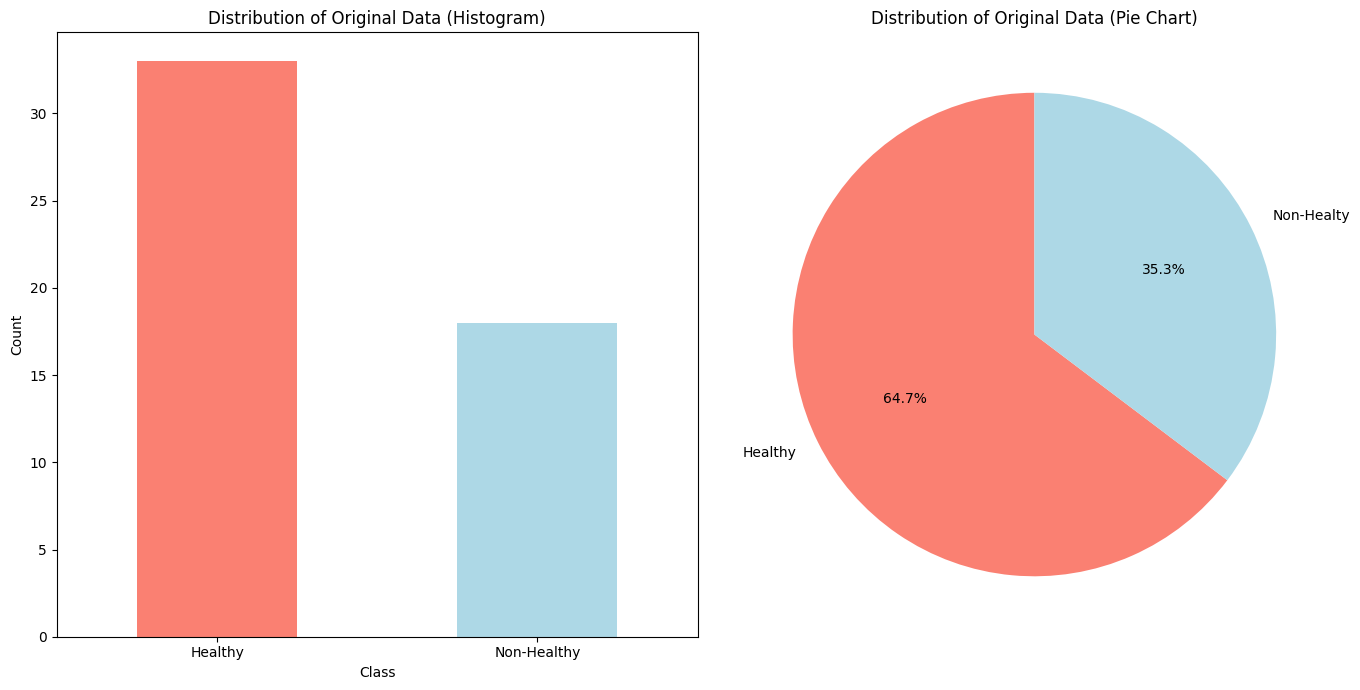

In [7]:
labels_series = pd.Series(labels)
labels_series = labels_series.map({0: 'Alive', 1: 'Death'})
class_counts = labels_series.value_counts()
print(f'The class counts are: {class_counts}')

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Histogram plot
class_counts.plot(kind='bar', color=["salmon", "lightblue"], ax=ax[0])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of Original Data (Histogram)')
ax[0].set_xticks(range(len(class_counts)))
ax[0].set_xticklabels(['Healthy', 'Non-Healthy'], rotation=0)

# Pie chart on the second subplot
class_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=["salmon", "lightblue"], labels=['Healthy', 'Non-Healty'], ax=ax[1])
ax[1].set_title('Distribution of Original Data (Pie Chart)')
ax[1].set_ylabel('')  # Hide the y-label for the pie chart

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

## Step 2: Data Preparation

#### 1. fNIRS `dataset` from `data` and `labels`

- We want to do `Holdout Validation` which mean split the data into `80%` for training and `20%` for testing using `scikit-learn` library
- According to this [Research Paper](https://arxiv.org/abs/1804.07612), the best training performance was observed during `b=2` to `b=32`, explicitly the option of `batch_size` is **2, 4, 8, 16, 32**

**Create a Dataset and Dataloader**

In [5]:
class fNIRSDataModule(pl.LightningDataModule):
    def __init__(self, data_path, task_type, batch_size=32, oversampling=False):
        super().__init__()
        self.data_path = data_path
        self.task_type = task_type
        self.batch_size = batch_size
        self.oversampling = oversampling

    def prepare_data(self):
        # Load fnirs data and create labels
        fNIRS_data_dict = du.load_concatenated_fNIRS_data(self.data_path, self.task_type)
        self.data, self.labels = du.create_data_and_labels(fNIRS_data_dict)

    def setup(self, stage=None):
        # Split the data into train and test sets
        data_HbO = self.data[:, :23]
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            data_HbO, self.labels, test_size=0.2, stratify=self.labels, random_state=42
        )

        # Check the shape of the training data
        num_subjects, num_channels, num_timepoints = self.train_data.shape
        print(f"Original train data shape: {self.train_data.shape}")

        # Use einops to reshape the 3D data to 2D: (samples, channels * time_points)
        reshaped_train_data = rearrange(self.train_data, 's c t -> s (c t)')

        if self.oversampling:
            # Apply SMOTE to the reshaped data
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            reshaped_train_data, self.train_labels = smote.fit_resample(reshaped_train_data, self.train_labels)

            # Use einops to reshape the data back to 3D: (samples, channels, time_points)
            self.train_data = rearrange(reshaped_train_data, 's (c t) -> s c t', c=num_channels, t=num_timepoints)

            # Print the new shape and class distribution after SMOTE
            print(f"Reshaped train data after SMOTE: {self.train_data.shape}")
            print(f"Class distribution after SMOTE: {Counter(self.train_labels)}")


    def train_dataloader(self):
        # Create dataset and dataloader for training data
        train_dataset = self.fNIRSDataset(self.train_data, self.train_labels)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        # Create dataset and dataloader for test data
        test_dataset = self.fNIRSDataset(self.test_data, self.test_labels)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    class fNIRSDataset(Dataset):
        def __init__(self, data, labels):
            self.data = torch.tensor(data, dtype=torch.float32)
            self.labels = torch.tensor(labels, dtype=torch.int64)

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            # Return a single sample (data, label)
            return self.data[idx], self.labels[idx]

In [6]:
# Example usage
df_10_1_Hz_truncated = Path('../../data/truncated/10_1_Hz')
task_type = 'GNG'

data_module = fNIRSDataModule(df_10_1_Hz_truncated, task_type, batch_size=8, oversampling=True)
data_module.prepare_data()
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

Original train data shape: (40, 23, 2424)
Reshaped train data after SMOTE: (52, 23, 2424)
Class distribution after SMOTE: Counter({0: 26, 1: 26})


c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


## Step 3: Model Building

### 1. Build a Training Pipeline

- We create a seperate method to handle `train`, `val`, `predict` and `TrainingConfiguration`

In [7]:
from torchmetrics import MeanMetric
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryAUROC, BinaryConfusionMatrix
import seaborn as sns

class fNIRSModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """

        super().__init__()
        self.save_hyperparameters()
        self.model = create_model(model_name, model_hparams)  # type: ignore # noqa: F821
        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros(1, 23, 2424, dtype=torch.float32)

        # Metrics for training
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = BinaryAccuracy()

        # Metrics for validation
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = BinaryAccuracy()

        # Metrics for testing
        self.test_preds = []
        self.test_targets = []
        self.mean_test_acc = BinaryAccuracy()
        self.test_f1 = BinaryF1Score()
        self.test_auroc = BinaryAUROC()
        self.test_conf_matrix = BinaryConfusionMatrix()

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        if self.hparams.optimizer_name == 'Adam':
            optimizer = torch.optim.AdamW(self.model.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.model.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: {self.hparams.optimizer_name}"

        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1
        )
        return [optimizer], [scheduler]

    
    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        output = self.model(data)
        loss = self.loss_module(output, target)
        pred_batch = output.detach().argmax(dim=1)

        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_acc(pred_batch, target)

        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True, on_epoch=True)
        self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True, on_epoch=True)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        data, target = batch
        output = self.model(data)
        loss = self.loss_module(output, target)
        pred_batch = output.argmax(dim=1)

        # Update validation metrics
        self.mean_valid_loss(loss, weight=data.shape[0])    
        self.mean_valid_acc(pred_batch, target)

    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self.model(data)
        pred_batch = output.argmax(dim=1)

        # Update test metrics (accuracy, F1 score, AUROC, and confusion matrix)
        self.mean_test_acc(pred_batch, target)
        
        # Store predictions and labels for confusion matrix
        self.test_preds.append(pred_batch)
        self.test_targets.append(target)

    def on_validation_epoch_end(self):
        """Calculate epoch level metrics for the validation set"""

        self.log("valid/loss", self.mean_valid_loss, prog_bar=True, logger=True, on_epoch=True)
        self.log("valid/acc", self.mean_valid_acc, prog_bar=True, logger=True, on_epoch=True)


    def on_test_epoch_end(self):
        """Calculate final metrics for the test set after all batches have been processed."""
        
        # Concatenate all predictions and targets across batches
        final_preds = torch.cat(self.test_preds)
        final_targets = torch.cat(self.test_targets)

        # Compute final test metrics
        test_acc = self.mean_test_acc.compute()
        test_f1 = self.test_f1(final_preds, final_targets)
        test_auroc = self.test_auroc(final_preds, final_targets)
        test_conf_matrix = self.test_conf_matrix(final_preds, final_targets)

        # Move confusion matrix to CPU and convert to NumPy
        test_conf_matrix_cpu = test_conf_matrix.cpu().numpy()

        # Plot confusion matrix
        self.plot_confusion_matrix(test_conf_matrix_cpu)

        # Log the final metrics
        self.log("test/acc", test_acc)
        self.log("test/f1", test_f1)
        self.log("test/auroc", test_auroc)

        # Optionally print the confusion matrix
        print("Test Confusion Matrix:\n", test_conf_matrix)

        # Reset metrics for the next test run (if applicable)
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_conf_matrix.reset()

        # Clear stored predictions and targets
        self.test_preds.clear()
        self.test_targets.clear()

    def plot_confusion_matrix(self, cm):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, 
                    xticklabels=['Predicted Healthy', 'Predicted Non-Healthy'], 
                    yticklabels=['Healthy', 'Non-Healthy'])
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title("Confusion Matrix")

        # Log confusion matrix to TensorBoard
        self.logger.experiment.add_figure("Confusion Matrix", fig, self.current_epoch)
        plt.close(fig)

In [11]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

### 2. Training Model

In [8]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, RichModelSummary
CHECKPOINT_PATH = Path('./saved_models/tensorboard')

In [13]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Crreate a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                            # Where to save models
                         accelerator='gpu' if str(device).startswith("cuda") else "cpu",                       # We run on a GPU (if possible)
                         devices=1,                                                                            # How many GPUs/CPUs we want to use (1 is enough for the notebooks)
                         max_epochs=100,                                                                      # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="valid/acc"),    # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor(logging_interval='epoch'),
                                    RichModelSummary(max_depth=3)],                            # Log learning rate every epoch
                        enable_progress_bar=True,
                        log_every_n_steps=1)                                                               
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    pl.seed_everything(42)
    model = fNIRSModule(model_name=model_name, **kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = fNIRSModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation set and test set (if available)
    val_result = trainer.test(model, test_loader, verbose=False)

    return model, val_result

#### 1. LeNet 1D

In [ ]:
model_dict["LeNet1D"] = pm.LeNet1D

lenet1d_model, lenet1d_results = train_model(model_name="LeNet1D",
                                             model_hparams={"input_channels": 23,
                                                        "input_length": 2424,
                                                        "num_classes": 2, 
                                                        "act_fn_name": "relu"},
                                             optimizer_name="Adam",
                                             optimizer_hparams={"lr": 1e-3, 
                                                        "weight_decay": 1e-4})

In [41]:
lenet1d_results

[{'test/acc': 0.7272727489471436,
  'test/f1': 0.4000000059604645,
  'test/auroc': 0.625}]

#### 2. AlexNet 1D

In [18]:
model_dict["AlexNet1D"] = pm.AlexNet1D

alexnet1d_model, alexnet1d_results = train_model(model_name="AlexNet1D",
                                                 model_hparams={"input_channels": 23,
                                                        "input_length": 2424,
                                                        "num_classes": 2, 
                                                        "act_fn_name": "relu"},
                                                optimizer_name="Adam",
                                                optimizer_hparams={"lr": 1e-3, 
                                                        "weight_decay": 1e-4})

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃    ┃ Name             ┃ Type                  ┃ Params ┃ Mode  ┃      In sizes ┃     Out sizes ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 0  │ model            │ AlexNet1D             │  3.4 M │ train │ [1, 23, 2424] │        [1, 2] │
│ 1  │ model.body       │ Sequential            │  793 K │ train │ [1, 23, 2424] │   [1, 256, 6] │
│ 2  │ model.body.0     │ Conv1d                │ 16.3 K │ train │ [1, 23, 2424] │  [1, 64, 605] │
│ 3  │ model.body.1     │ BatchNorm1d           │    128 │ train │  [1, 64, 605] │  [1, 64, 605] │
│ 4  │ model.body.2     │ ReLU                  │      0 │ train │  [1, 64, 605] │  [1, 64, 605] │
│ 5  │ model.body.3     │ MaxPool1d             │      0 │ train │  [1, 64, 605] │  [1, 64, 302] │
│ 6  │ model.body.4     │ Conv1d                │ 61.6 K │ train │  [1, 64, 302] │ [1, 192, 302] │
│ 7  │ model.body.5     │ BatchNorm1d           │    384 │ train │ [1, 192, 302] │ [1, 192, 302] │
│ 8  │ model.body.6     │ ReLU                  │      0 │ train │ [1, 192, 302] │ [1, 192, 302] │
│ 9  │ model.body.7     │ MaxPool1d             │      0 │ train │ [1, 192, 302] │ [1, 192, 150] │
│ 10 │ model.body.8     │ Conv1d                │  221 K │ train │ [1, 192, 150] │ [1, 384, 150] │
│ 11 │ model.body.9     │ BatchNorm1d           │    768 │ train │ [1, 384, 150] │ [1, 384, 150] │
│ 12 │ model.body.10    │ ReLU                  │      0 │ train │ [1, 384, 150] │ [1, 384, 150] │
│ 13 │ model.body.11    │ Conv1d                │  295 K │ train │ [1, 384, 150] │ [1, 256, 150] │
│ 14 │ model.body.12    │ BatchNorm1d           │    512 │ train │ [1, 256, 150] │ [1, 256, 150] │
│ 15 │ model.body.13    │ ReLU                  │      0 │ train │ [1, 256, 150] │ [1, 256, 150] │
│ 16 │ model.body.14    │ Conv1d                │  196 K │ train │ [1, 256, 150] │ [1, 256, 150] │
│ 17 │ model.body.15    │ BatchNorm1d           │    512 │ train │ [1, 256, 150] │ [1, 256, 150] │
│ 18 │ model.body.16    │ ReLU                  │      0 │ train │ [1, 256, 150] │ [1, 256, 150] │
│ 19 │ model.body.17    │ MaxPool1d             │      0 │ train │ [1, 256, 150] │  [1, 256, 74] │
│ 20 │ model.body.18    │ AdaptiveAvgPool1d     │      0 │ train │  [1, 256, 74] │   [1, 256, 6] │
│ 21 │ model.head       │ Sequential            │  2.6 M │ train │     [1, 1536] │        [1, 2] │
│ 22 │ model.head.0     │ Dropout               │      0 │ train │     [1, 1536] │     [1, 1536] │
│ 23 │ model.head.1     │ Linear                │  1.6 M │ train │     [1, 1536] │     [1, 1024] │
│ 24 │ model.head.2     │ ReLU                  │      0 │ train │     [1, 1024] │     [1, 1024] │
│ 25 │ model.head.3     │ Dropout               │      0 │ train │     [1, 1024] │     [1, 1024] │
│ 26 │ model.head.4     │ Linear                │  1.0 M │ train │     [1, 1024] │     [1, 1024] │
│ 27 │ model.head.5     │ ReLU                  │      0 │ train │     [1, 1024] │     [1, 1024] │
│ 28 │ model.head.6     │ Linear                │  2.0 K │ train │     [1, 1024] │        [1, 2] │
│ 29 │ loss_module      │ CrossEntropyLoss      │      0 │ train │             ? │             ? │
│ 30 │ mean_train_loss  │ MeanMetric            │      0 │ train │             ? │             ? │
│ 31 │ mean_train_acc   │ BinaryAccuracy        │      0 │ train │             ? │             ? │
│ 32 │ mean_valid_loss  │ MeanMetric            │      0 │ train │             ? │             ? │
│ 33 │ mean_valid_acc   │ BinaryAccuracy        │      0 │ train │             ? │             ? │
│ 34 │ mean_test_acc    │ BinaryAccuracy        │      0 │ train │             ? │             ? │
│ 35 │ test_f1          │ BinaryF1Score         │      0 │ train │             ? │             ? │
│ 36 │ test_auroc       │ BinaryAUROC           │      0 │ train │             ? │             ? │
│ 37 │ test_conf_matrix │ BinaryConfusio

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 38                                                                                          
Modules in eval mode: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\LENOVO X1E\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\LENOVO X1E\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\LENOVO X1E\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test Confusion Matrix:
 tensor([[7, 0],
        [3, 1]], device='cuda:0')


In [39]:
alexnet1d_results

[{'test/acc': 0.7272727489471436,
  'test/f1': 0.4000000059604645,
  'test/auroc': 0.625}]

#### 3. TCN

In [14]:
model_dict["TCN"] = pm.TCN

tcn_model, tcn_results = train_model(model_name="TCN",
                                     model_hparams={"num_inputs": 23,
                                                    "num_channels": [64, 128, 256],
                                                    "num_classes": 2},                                                  
                                    optimizer_name="Adam",
                                    optimizer_hparams={"lr": 1e-3, 
                                            "weight_decay": 1e-4})

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
c:\ProgramData\miniconda3\envs\fnirs\lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃    ┃ Name               ┃ Type                  ┃ Params ┃ Mode  ┃      In sizes ┃      Out sizes ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ 0  │ model              │ TCNForClassification  │ 79.7 M │ train │ [1, 23, 2424] │         [1, 2] │
│ 1  │ model.body         │ TemporalConvNet       │  301 K │ train │ [1, 23, 2424] │ [1, 256, 2424] │
│ 2  │ model.body.network │ Sequential            │  301 K │ train │ [1, 23, 2424] │ [1, 256, 2424] │
│ 3  │ model.head         │ Sequential            │ 79.4 M │ train │   [1, 620544] │         [1, 2] │
│ 4  │ model.head.0       │ Dropout               │      0 │ train │   [1, 620544] │    [1, 620544] │
│ 5  │ model.head.1       │ Linear                │ 79.4 M │ train │   [1, 620544] │       [1, 128] │
│ 6  │ model.head.2       │ ReLU                  │      0 │ train │      [1, 128] │       [1, 128] │
│ 7  │ model.head.3       │ Linear                │    258 │ train │      [1, 128] │         [1, 2] │
│ 8  │ loss_module        │ CrossEntropyLoss      │      0 │ train │             ? │              ? │
│ 9  │ mean_train_loss    │ MeanMetric            │      0 │ train │             ? │              ? │
│ 10 │ mean_train_acc     │ BinaryAccuracy        │      0 │ train │             ? │              ? │
│ 11 │ mean_valid_loss    │ MeanMetric            │      0 │ train │             ? │              ? │
│ 12 │ mean_valid_acc     │ BinaryAccuracy        │      0 │ train │             ? │              ? │
│ 13 │ mean_test_acc      │ BinaryAccuracy        │      0 │ train │             ? │              ? │
│ 14 │ test_f1            │ BinaryF1Score         │      0 │ train │             ? │              ? │
│ 15 │ test_auroc         │ BinaryAUROC           │      0 │ train │             ? │              ? │
│ 16 │ test_conf_matrix   │ BinaryConfusionMatrix │      0 │ train │             ? │              ? │
└────┴────────────────────┴───────────────────────┴────────┴───────┴───────────────┴────────────────┘

Trainable params: 79.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 79.7 M                                                                                               
Total estimated model params size (MB): 318                                                                        
Modules in train mode: 53                                                                                          
Modules in eval mode: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\LENOVO X1E\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\LENOVO X1E\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\LENOVO X1E\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test Confusion Matrix:
 tensor([[7, 0],
        [4, 0]], device='cuda:0')


In [19]:
tcn_results

[{'test/acc': 0.6363636255264282, 'test/f1': 0.0, 'test/auroc': 0.5}]

### 3. Plotting

In [9]:
%load_ext tensorboard

%tensorboard --logdir ./saved_models/tensorboard/AlexNet1D/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 35860), started 4:21:12 ago. (Use '!kill 35860' to kill it.)

Reusing TensorBoard on port 6006 (pid 35860), started 4:18:09 ago. (Use '!kill 35860' to kill it.)